In [ ]:
from nbdev import *

In [ ]:
%nbdev_default_export train_utils_fastai2

Cells will be exported to imagenette_experiments.train_utils_fastai2,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# train_utils_fastai2

> Basic utils for experiments - create dataloaders, learner with fastai v2.

# imports

In [ ]:
%nbdev_export
from fastai2.vision.all import *
from fastscript.core import Param
from model_constructor.net import *

In [ ]:
%nbdev_hide
xresnet50

<function fastai2.vision.models.xresnet.xresnet50(pretrained=False, **kwargs)>

# Dls

In [ ]:
%nbdev_export
def get_dls(size, woof, bs, sh=0., workers=None):
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if sh: batch_tfms.append(RandomErasing(p=0.3, max_count=3, sh=sh))
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

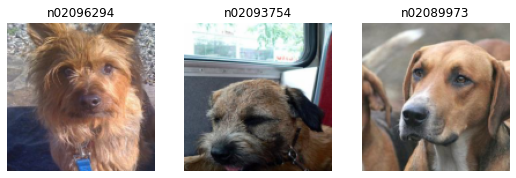

In [ ]:
dls = get_dls(128,1,16)
dls.show_batch(max_n=3)

# Learner

In [ ]:
%nbdev_export
def get_learn(
    gpu:   Param("GPU to run on", int)=None,
    woof:  Param("Use imagewoof (otherwise imagenette)", int)=0,
    lr:    Param("Learning rate", float)=1e-2,
    size:  Param("Size (px: 128,192,256)", int)=128,
    sqrmom:Param("sqr_mom", float)=0.99,
    mom:   Param("Momentum", float)=0.9,
    eps:   Param("epsilon", float)=1e-6,
    epochs:Param("Number of epochs", int)=5,
    bs:    Param("Batch size", int)=64,
    mixup: Param("Mixup", float)=0.,
    opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='ranger',
    arch:  Param("Architecture", str)='xresnet50',
    sh:    Param("Random erase max proportion", float)=0.,
    sa:    Param("Self-attention", int)=0,
    sym:   Param("Symmetry for self-attention", int)=0,
    beta:  Param("SAdam softplus beta", float)=0.,
    act_fn:Param("Activation function", str)='Mish',
    fp16:  Param("Use mixed precision training", int)=0,
    pool:  Param("Pooling method", str)='AvgPool',
    dump:  Param("Print model; don't train", int)=0,
    runs:  Param("Number of times to repeat training", int)=1,
    meta:  Param("Metadata (ignored)", str)='',
    model: Param("Model for learner", bool)=None
):
    "Create Learner for Imagenette"

    # gpu = setup_distrib(gpu)
    if gpu is not None: torch.cuda.set_device(gpu)
    if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=sqrmom)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
    elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

    dls = get_dls(size, woof, bs, sh=sh)
    if not gpu: print(f'{"imagewoof" if woof else "imagenette"}, size: {size}; bs: {bs}; ')

    m,act_fn,pool = [globals()[o] for o in (arch,act_fn,pool)]

    
    if not model: model = partial(m, n_out=10, act_cls=act_fn, sa=sa, sym=sym, pool=pool)
    learn = Learner(dls, model(), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    
    if fp16: learn = learn.to_fp16()
    return learn

In [ ]:
%nbdev_hide
#     cbs = MixUp(mixup) if mixup else []
    
    
#     for run in range(runs):
#         print(f'Run: {run}')
#         learn = Learner(dls, m(n_out=10, act_cls=act_fn, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
#                 metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
#         if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
#         cbs = MixUp(mixup) if mixup else []

#         n_gpu = torch.cuda.device_count()

#         # The old way to use DataParallel, or DistributedDataParallel training:
#         # if gpu is None and n_gpu: learn.to_parallel()
#         # if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai2.launch`

#         # the context manager way of dp/ddp, both can handle single GPU base case.
#         ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx

#         with partial(ctx, gpu)(): # distributed traing requires "-m fastai2.launch"
#             print(f"Training in {ctx.__name__} context on GPU {gpu if gpu is not None else list(range(n_gpu))}")
#             learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)


In [ ]:
learn = get_learn(size=128, bs=64, woof=1)

imagewoof, size: 128; bs: 64; 


In [ ]:
%nbdev_collapse_output
learn.model

XResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Mish()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
%nbdev_hide
# learn.fit_flat_cos(5, 8e-3, wd=1e-2, )

In [ ]:
from model_constructor.yaresnet import *

In [ ]:
%nbdev_collapse_output
model = yaresnet50(c_out=10)
model

YaResnet50 constructor
 expansion: 4, sa: 0, groups: 1
 stem sizes: [3, 32, 64, 64]
 body sizes [16, 64, 128, 256, 512]

In [ ]:
learn = get_learn(size=128, bs=64, woof=1, model=model)

imagewoof, size: 128; bs: 64; 


In [ ]:
%nbdev_collapse_output
learn.model

Sequential(
  model YaResnet50
  (stem): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (stem_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (l_0): Sequential(
      (bl_0): YaResBlock(
        (convs): Sequential(
          (conv_0): ConvLayer(
       

In [ ]:
%nbdev_hide
# learn.fit_flat_cos(5, 8e-3, wd=1e-2, )

# end